In [33]:
import pdftotext
import logging
import spacy
import joblib
import logging
import numpy as np
import matplotlib.pyplot as plt
import os

In [34]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [35]:
class_mapping = {
    'ACCOUNTANT': 0,
    'ADVOCATE': 1,
    'AGRICULTURE': 2,
    'APPAREL': 3,
    'ARTS': 4,
    'AUTOMOBILE': 5,
    'AVIATION': 6,
    'BANKING': 7,
    'BPO': 8,
    'BUSINESS-DEVELOPMENT': 9,
    'CHEF': 10,
    'CONSTRUCTION': 11,
    'CONSULTANT': 12,
    'DESIGNER': 13,
    'DIGITAL-MEDIA': 14,
    'ENGINEERING': 15,
    'FINANCE': 16,
    'FITNESS': 17,
    'HEALTHCARE': 18,
    'HR': 19,
    'INFORMATION-TECHNOLOGY': 20,
    'PUBLIC-RELATIONS': 21,
    'SALES': 22,
    'TEACHER': 23,
    'ARCHITECT' :24
}

In [36]:
senior_mapping = {
    'Junior': 0,
    'Pleno': 1,
    'Senior': 2,
}

In [37]:
model = joblib.load("../../app/AIModel/domain/model_class.pkl")
vectorizer = joblib.load("../../app/AIModel/domain/vector_class.pkl")

model_senior = joblib.load("../../app/AIModel/domain/model_senior.pkl")
vectorizer_senior = joblib.load("../../app/AIModel/domain/vector_senior.pkl")
nlp = spacy.load("en_core_web_lg")

In [38]:
def remove_stopwords_and_lemmatize(text):
    cleaned_text = ' '.join(text.strip().split())
    doc = nlp(cleaned_text.lower())
    tokens_lemmatized = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens_lemmatized)

In [39]:
def extract_text_from_pdf(pdf_file):
    with open(pdf_file, "rb") as f:
        pdf = pdftotext.PDF(f)
    return "\n\n".join(pdf)

In [40]:
def process_pdf_and_classify(pdf_file):
    text = extract_text_from_pdf(pdf_file)
    preprocessed_text = remove_stopwords_and_lemmatize(text)
    X = np.array([preprocessed_text])
    X_vec = vectorizer.transform(X)
    probabilities = model.predict_proba(X_vec)
    return probabilities

In [41]:
def top_probabilities(probabilities):
    prob_list = list(probabilities[0])
    sorted_indices = sorted(range(len(prob_list)), key=lambda i: prob_list[i], reverse=True)[:5]
    for idx in sorted_indices:
        class_name = [key for key, value in class_mapping.items() if value == idx][0]
        prob_percent = prob_list[idx] * 100
        logger.info(f"{class_name}: {prob_percent:.2f}%")


In [42]:
def plot_percentage_bar(decimal_percentage):
    labels = ['']
    values = [decimal_percentage]
    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color='green')
    plt.title(f"Accuracy: {decimal_percentage}%")
    plt.ylabel('%')
    plt.ylim(0, 1) 
    plt.grid(True)
    plt.show()

In [43]:
def process_pdf_and_classify_senior(pdf_file):
    text = extract_text_from_pdf(pdf_file)
    preprocessed_text = remove_stopwords_and_lemmatize(text)
    X = np.array([preprocessed_text])
    X_vec = vectorizer_senior.transform(X)
    probabilities = model_senior.predict_proba(X_vec)
    return probabilities

In [44]:
def top_probabilities_senior(probabilities):
    prob_list = list(probabilities[0])
    sorted_indices = sorted(range(len(prob_list)), key=lambda i: prob_list[i], reverse=True)[:3]
    for idx in sorted_indices:
        class_name = [key for key, value in senior_mapping.items() if value == idx][0]
        prob_percent = prob_list[idx] * 100
        logger.info(f"{class_name}: {prob_percent:.2f}%")


In [45]:
pdf_file = 'db/13.pdf'
probabilities = process_pdf_and_classify(pdf_file)
top_probabilities(probabilities) 

2024-07-05 09:07:38,960 - INFO - ENGINEERING: 94.25%
2024-07-05 09:07:38,961 - INFO - AUTOMOBILE: 2.43%
2024-07-05 09:07:38,962 - INFO - DIGITAL-MEDIA: 0.87%
2024-07-05 09:07:38,962 - INFO - ARTS: 0.50%
2024-07-05 09:07:38,963 - INFO - TEACHER: 0.47%


In [46]:
pdf_file = 'db/13.pdf'
probabilities = process_pdf_and_classify_senior(pdf_file)
top_probabilities_senior(probabilities) 

2024-07-05 09:07:39,157 - INFO - Junior: 92.38%
2024-07-05 09:07:39,161 - INFO - Pleno: 7.58%
2024-07-05 09:07:39,161 - INFO - Senior: 0.04%


In [47]:
def classify_pdfs_in_folder(folder_path):
    classifications = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            pdf_file = os.path.join(folder_path, filename)
            probabilities = process_pdf_and_classify(pdf_file)
            top_indices = np.argsort(probabilities[0])[::-1][:1]
            predicted_class = [key for key, value in class_mapping.items() if value == top_indices[0]][0]
            correct_class = filename.split(".")[0]
            classifications.append(1 if predicted_class == correct_class else 0)
            if predicted_class == correct_class:
                logger.info(f"+CORRECT classification: {predicted_class} (filename: {filename})")
            else:
                logger.info(f"-INCORRECT classification: predicted {predicted_class}, (filename: {filename})")
    return classifications

In [48]:
classification = classify_pdfs_in_folder("db")

2024-07-05 09:07:39,426 - INFO - -INCORRECT classification: predicted AUTOMOBILE, (filename: 7.pdf)
2024-07-05 09:07:39,726 - INFO - -INCORRECT classification: predicted ENGINEERING, (filename: 10.pdf)
2024-07-05 09:07:39,919 - INFO - -INCORRECT classification: predicted AUTOMOBILE, (filename: 4.pdf)
2024-07-05 09:07:40,113 - INFO - -INCORRECT classification: predicted ENGINEERING, (filename: 15.pdf)
2024-07-05 09:07:40,281 - INFO - -INCORRECT classification: predicted ENGINEERING, (filename: 2.pdf)
2024-07-05 09:07:40,457 - INFO - -INCORRECT classification: predicted INFORMATION-TECHNOLOGY, (filename: 17.pdf)
2024-07-05 09:07:40,653 - INFO - -INCORRECT classification: predicted FINANCE, (filename: 19.pdf)
2024-07-05 09:07:40,830 - INFO - -INCORRECT classification: predicted SALES, (filename: 8.pdf)
2024-07-05 09:07:41,009 - INFO - -INCORRECT classification: predicted ENGINEERING, (filename: 13.pdf)
2024-07-05 09:07:41,265 - INFO - -INCORRECT classification: predicted FINANCE, (filenam

IndexError: list index out of range

In [ ]:
accu = sum(classification)/len(classification)

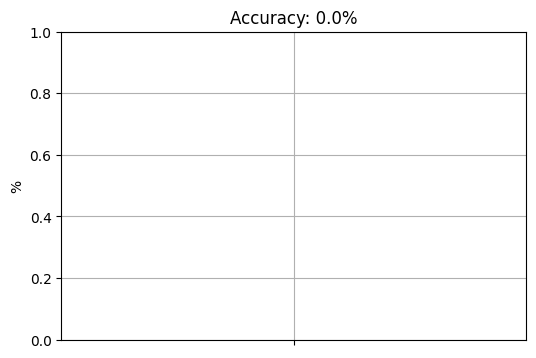

In [ ]:
plot_percentage_bar(accu)